## Josh Broomberg
## Assignment 1

### Question 1: Linear Regression to Validate Moore's Law

Below, a straight forward linear regression is applied to a CPU benchmark dataset in order to validate Moore's law. Regessing performence onto time, the models shows a coefficient of 1.66 on year. Parameter accuracy aside, this value implies Moore's law is pretty much accurate because it indicates performence close to doubles each year. In order to know whether this is accurate, we can consider two methods. First, in 'applied' machine learning, we would consider the accuracy of this predictor on unseen data. The predictor as an $r^2$ of $0.72$, which means it explains a large portion of the variance of performence across time. Second, we could consider the statistical significance of the parameter. Using the statesmodel package, we can see that the year variable has a p value of $5.542018 \times 10^{-143}$ on the hypothesis test with that its value is 0. This is strong evidence that year is a predictor performence. The 95% confidence interval around the value has lower bound 1.61 and upper bound 1.7. So,we can be fairly sure that Moore's law holds. 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import datasets, linear_model, neighbors
from sklearn import metrics
from sklearn.cross_validation import train_test_split

from scipy import stats
from sklearn.model_selection import cross_validate
import statsmodels.formula.api as smf

In [49]:
### Read Data

# Function to convert variable format
# dates into unix time stamps (seconds from epoch)
def convert_date(full_date_str):
    try:
        date_str = full_date_str.split("-")[1]
        if len(date_str) == 8:
            format_str = "%Y%m%d"
        else:
            format_str = "%y%m%d"
            
        return int(datetime.strptime(date_str, format_str).strftime("%s"))
    except:
        # Return flag for rows to be removed later.
        return 0
    
# Read CSV
benchmarks = np.loadtxt("benchmarks.txt",
    delimiter=",",
    dtype='O',
    converters={
        0: convert_date,
        2: lambda str: float(str)},
    skiprows=1,
    usecols=(0, 1, 2))

# Place CSV into Pandas Frame.
benchmark_data = pd.DataFrame(benchmarks, columns=["date", "name", "score"])
benchmark_data.head()

,date,name,score
0,915408000,101.tomcatv,19.4
1,915408000,102.swim,27.2
2,915408000,103.su2cor,10.1
3,915408000,104.hydro2d,8.58
4,915408000,107.mgrid,8.94


** Clean and filter data:**

Num data points: 494


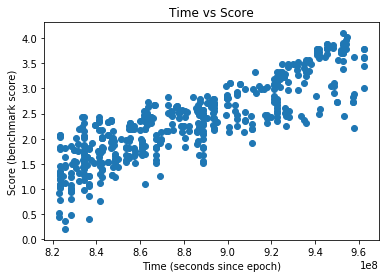

In [50]:
# Remove rows without dates.
cleaned_benchmark_data = benchmark_data[benchmark_data.date != 0]

# Specify benchmark and filter.
selected_benchmark = '130.li'
filtered_benchmark_data = cleaned_benchmark_data[cleaned_benchmark_data['name'].str.match(selected_benchmark)]

print("Num data points: {}".format(len(filtered_benchmark_data.index)))

x_time = filtered_benchmark_data.date
filtered_benchmark_data = filtered_benchmark_data.assign(ln_score = lambda x: np.log(x.score.astype(float)))
y_score = filtered_benchmark_data.ln_score

plt.title("Time vs Score")
plt.xlabel("Time (seconds since epoch)")
plt.ylabel("Score (benchmark score)")
plt.scatter(x_time, y_score)
plt.show()

** Fit model **

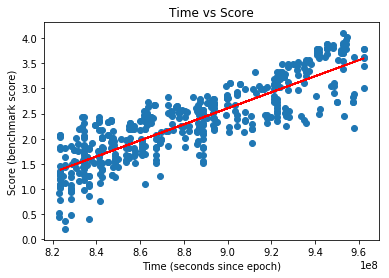

Score multiple per year: 1.65443680518


In [51]:
# Split data for training and test
x_train, x_test, y_train, y_test = train_test_split(x_time, y_score, test_size=0.1, random_state=50)

# Fit linear model
regr = linear_model.LinearRegression()
regr.fit(x_train.values.reshape(-1, 1), y_train)

# Run predictions
y_predicted_score = regr.predict(x_test.values.reshape(-1, 1))

plt.title("Time vs Score")
plt.xlabel("Time (seconds since epoch)")
plt.ylabel("Score (benchmark score)")
plt.scatter(x_time, y_score)
plt.plot(x_test, y_predicted_score, color="r")
plt.show()

# Recover coefficient in the correct units:
raw_coeff = regr.coef_[0]
coeff = np.exp(raw_coeff*(60*60*24*365))
print("Score multiple per year: {}".format(coeff))

** Evaluate model **

In [52]:
metrics_to_run = [metrics.mean_squared_error, metrics.mean_absolute_error, metrics.median_absolute_error, metrics.r2_score]
for metric in metrics_to_run: 
    print("{}: {}".format(metric.__name__, metric(y_predicted_score, y_test)))

mean_squared_error: 0.13114196506
mean_absolute_error: 0.297077238208
median_absolute_error: 0.253546596866
r2_score: 0.720497803354


** Statistical Significance **

In [69]:
filtered_benchmark_data_2 = filtered_benchmark_data.assign(date = lambda x: pd.to_numeric(x.date, errors='coerce'))
lm1 = smf.ols(formula='ln_score ~ date', data=filtered_benchmark_data_2).fit()

# print the coefficients
print(lm1.params)
print("P values:")
print(lm1.pvalues)
print
print("Confidence intervals:")
lower = lm1.conf_int()[0][1]
print("Lower: {}".format(np.exp(lower*(60*60*24*365))))
upper = lm1.conf_int()[1][1]
print("Upper: {}".format(np.exp(upper*(60*60*24*365))))


Intercept   -1.174578e+01
date         1.595490e-08
dtype: float64
P values:
Intercept    3.464849e-116
date         5.542018e-143
dtype: float64

Confidence intervals:
Lower: 1.60997753584
Upper: 1.69908015658


### Question 2: K-Nearest Neighbours for MNIST

Below, a K-nearest Neighbours is applied to the MNIST dataset in order to classify digits. The first step uses cross-validation to determine the best value for the number of neighbours to consider and the weighting (uniform or distance). The second step is to fit a model using these params, and test it on the reserved test set. 

The code is structured to allow for flexible selection of the classification challenge. The numbers to be classified are supplied at run time. If two digits are supplied, the challenge is binary classification, and F1 scoring is used. If more than 2 digits are supplied, the standard sklearn accuracy score (average between precision and recall) is used.

First, a binary classification is attempted for 7 and 9. The best weighting is determing to be uniform, with 6 nearest neighbours considered. 

In [13]:
def binarize(arr):
    return [arr_item == arr[0] for arr_item in arr]

def run_mnist_classifier(digits_to_classify):
    binary = len(digits_to_classify) == 2
    
    digits = datasets.load_digits()

    # Filter set to contain only 2 digits
    conditions_arr = [digits.target == digit for digit in digits_to_classify]
    condition = conditions_arr[0]
    for condition_arr in conditions_arr:
        condition = np.logical_or(condition, condition_arr)
    selected_digit_indeces = np.where(condition)

    x_features = digits.data[selected_digit_indeces]
    
    y_label = digits.target[selected_digit_indeces]
    if binary:
        y_label = binarize(y_label)

    # Split to train and test
    # Use stratify to ensure proportional sampling of both classes
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_label,
        test_size=0.15, stratify=y_label, random_state=134)

    # Set k neighbours maximum to the sqrt of the number of points
    # as suggested by Barber.
    max_neighbors = int(np.sqrt(int(len(x_train))))

    for weights in ['uniform', 'distance']:
        print("Weights: {}".format(weights))
        for n_neighbors in range(1, max_neighbors):
            # Instantiate classifier with params
            # and fit to data
            clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

            # Run cross validation to check scores.
            
            # If binary, use F1 scoring, as this is best
            # in binary classification context.
            scoring = "accuracy"
            if binary:
                scoring = "f1"
                
            cv_scores = cross_validate(clf, X=x_train, y=y_train,
                                            cv=7, scoring=scoring)["test_score"]
            
            print ("Neighbors: {}, score: {}".format(n_neighbors, np.round(np.average(cv_scores), 5)))

        print
    
    return x_train, x_test, y_train, y_test, binary

x_train, x_test, y_train, y_test, binary = run_mnist_classifier(digits_to_classify=[7, 9])

Weights: uniform
Neighbors: 1, score: 0.9935
Neighbors: 2, score: 0.99668
Neighbors: 3, score: 0.99668
Neighbors: 4, score: 0.99668
Neighbors: 5, score: 0.99683
Neighbors: 6, score: 1.0
Neighbors: 7, score: 0.99683
Neighbors: 8, score: 0.9935
Neighbors: 9, score: 0.99379
Neighbors: 10, score: 0.99047
Neighbors: 11, score: 0.99088
Neighbors: 12, score: 0.99088
Neighbors: 13, score: 0.9881
Neighbors: 14, score: 0.9881
Neighbors: 15, score: 0.98542
Neighbors: 16, score: 0.9881

Weights: distance
Neighbors: 1, score: 0.9935
Neighbors: 2, score: 0.9935
Neighbors: 3, score: 0.99668
Neighbors: 4, score: 0.9935
Neighbors: 5, score: 0.99683
Neighbors: 6, score: 0.99683
Neighbors: 7, score: 0.99683
Neighbors: 8, score: 0.9935
Neighbors: 9, score: 0.99683
Neighbors: 10, score: 0.99047
Neighbors: 11, score: 0.99379
Neighbors: 12, score: 0.99088
Neighbors: 13, score: 0.99088
Neighbors: 14, score: 0.99088
Neighbors: 15, score: 0.9881
Neighbors: 16, score: 0.9881



**Fit the binary model**

Fir the model with 6 nearest neighbours and uniform weighting. This yields an F1 score of 1.0 on the reserved test data. 

In [16]:
clf = neighbors.KNeighborsClassifier(1, weights="uniform")
clf.fit(x_train, y_train)
predicted_classes = clf.predict(x_test)

if binary:
    metrics_to_run = [metrics.f1_score]
else:
    metrics_to_run = [metrics.accuracy_score]
    
for metric in metrics_to_run: 
    print("Primary {}: {}".format(metric.__name__, metric(predicted_classes, y_test)))

print
print("Classification report")
print(metrics.classification_report(y_test, predicted_classes))

Primary f1_score: 1.0

Classification report
             precision    recall  f1-score   support

      False       1.00      1.00      1.00        27
       True       1.00      1.00      1.00        27

avg / total       1.00      1.00      1.00        54



** Classifying all 10 digits **

Next, we use the same code to attempt to classify all 10 digits. Cross-validation shows 3 nearest neighbours with uniform weighting performs the best score. This yields a final accuracy of 0.9925 on the test set. 

In [17]:
x_train, x_test, y_train, y_test, binary = run_mnist_classifier(digits_to_classify=range(0, 10))

Weights: uniform
Neighbors: 1, score: 0.98494
Neighbors: 2, score: 0.9823
Neighbors: 3, score: 0.98817
Neighbors: 4, score: 0.98558
Neighbors: 5, score: 0.98624
Neighbors: 6, score: 0.98099
Neighbors: 7, score: 0.981
Neighbors: 8, score: 0.98035
Neighbors: 9, score: 0.98036
Neighbors: 10, score: 0.98168
Neighbors: 11, score: 0.98103
Neighbors: 12, score: 0.98168
Neighbors: 13, score: 0.97902
Neighbors: 14, score: 0.97642
Neighbors: 15, score: 0.97383
Neighbors: 16, score: 0.97517
Neighbors: 17, score: 0.97253
Neighbors: 18, score: 0.97188
Neighbors: 19, score: 0.97055
Neighbors: 20, score: 0.96923
Neighbors: 21, score: 0.96792
Neighbors: 22, score: 0.96727
Neighbors: 23, score: 0.96595
Neighbors: 24, score: 0.96793
Neighbors: 25, score: 0.96597
Neighbors: 26, score: 0.96531
Neighbors: 27, score: 0.96333
Neighbors: 28, score: 0.96335
Neighbors: 29, score: 0.96333
Neighbors: 30, score: 0.96268
Neighbors: 31, score: 0.96267
Neighbors: 32, score: 0.95875
Neighbors: 33, score: 0.95744
Neigh

In [18]:
clf = neighbors.KNeighborsClassifier(1, weights="uniform")
clf.fit(x_train, y_train)
predicted_classes = clf.predict(x_test)

if binary:
    metrics_to_run = [metrics.f1_score]
else:
    metrics_to_run = [metrics.accuracy_score]
    
for metric in metrics_to_run: 
    print("Primary {}: {}".format(metric.__name__, metric(predicted_classes, y_test)))
    
print
print("Classification report")
print(metrics.classification_report(y_test, predicted_classes))

Primary accuracy_score: 0.992592592593

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       1.00      1.00      1.00        27
          2       1.00      1.00      1.00        27
          3       0.97      1.00      0.98        28
          4       1.00      1.00      1.00        27
          5       0.96      1.00      0.98        27
          6       1.00      1.00      1.00        27
          7       1.00      1.00      1.00        27
          8       1.00      1.00      1.00        26
          9       1.00      0.93      0.96        27

avg / total       0.99      0.99      0.99       270

